In [25]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import gekko
import json

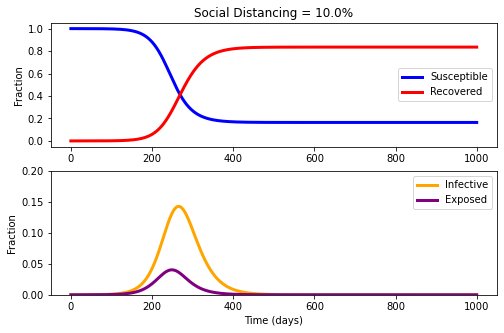

[0.99997016 0.99996987 0.99996908 ... 0.16453443 0.16453443 0.16453443]
[2.98356058e-05 2.47888118e-05 2.11037303e-05 ... 2.68804321e-10
 2.60797894e-10 2.52529275e-10]


In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

u = 0.1 # social distancing (0-1)
         # 0   = no social distancing
         # 0.1 = masks
         # 0.2 = masks and hybrid classes
         # 0.3 = masks, hybrid, and online classes

t_incubation = 5.1
t_infective = 20
R0 = 2.4
N = 33517 # students

# initial number of infected and recovered individuals
e0 = 1/N
i0 = 0.00
r0 = 0.00
s0 = 1 - e0 - i0 - r0
x0 = [s0,e0,i0,r0]

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def covid(x,t):
    s,e,i,r = x
    dx = np.zeros(4)
    dx[0] = -(1-u)*beta * s * i
    dx[1] = (1-u)*beta * s * i - alpha * e
    dx[2] = alpha * e - gamma * i
    dx[3] = gamma*i
    return dx

t = np.linspace(0, 1000, 1001)
x = odeint(covid,x0,t)
s = x[:,0]; e = x[:,1]; i = x[:,2]; r = x[:,3]

# plot the data
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
plt.title('Social Distancing = '+str(u*100)+'%')
plt.plot(t,s, color='blue', lw=3, label='Susceptible')
plt.plot(t,r, color='red',  lw=3, label='Recovered')
plt.ylabel('Fraction')
plt.legend()

plt.subplot(2,1,2)
plt.plot(t,i, color='orange', lw=3, label='Infective')
plt.plot(t,e, color='purple', lw=3, label='Exposed')
plt.ylim(0, 0.2)
plt.xlabel('Time (days)')
plt.ylabel('Fraction')
plt.legend()

plt.show()
print(s)
print(e)

[0.99999, 0.99999, 0.99999, 0.99998999999, 0.99998999995, 0.99998999972, 0.99998999887, 0.99998999549, 0.99998997235, 0.99998989283, 0.99998959602, 0.99998784035, 0.99998289513, 0.99997585844, 0.99996653054, 0.99995434822, 0.99993849042, 0.99991786365, 0.99989103847, 0.99985615406, 0.99981079044, 0.99975180131, 0.9996750967, 0.99957536073, 0.99944568539, 0.9992770958, 0.99905793532, 0.99877307018, 0.99840286236, 0.99792184595, 0.99729702633, 0.99648570268, 0.99543269411, 0.994066829, 0.99229654112, 0.9900044108, 0.98704050954, 0.98321447256, 0.97828637249, 0.97195674945, 0.96385664304, 0.95353925595, 0.94047603908, 0.92406153925, 0.90363310507, 0.87851293572, 0.84807981573, 0.81187421637, 0.76973121595, 0.72192015732, 0.66925168985, 0.61310177721, 0.5553120916, 0.49796400455, 0.44307698122, 0.3923207885, 0.34682688292, 0.30713872407, 0.2732836229, 0.24491345268, 0.2214583125, 0.20225583211, 0.18664153707, 0.17400185185, 0.16379868061, 0.15557558686, 0.14895369891, 0.14362287222, 0.1393

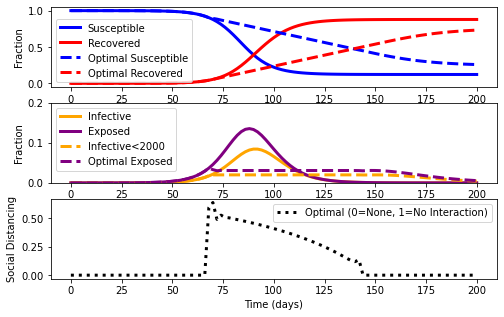

In [18]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

t_incubation = 5.1
t_infective = 3.3
R0 = 2.4
N = 100000

# fraction of infected and recovered individuals
e_initial = 1/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

m = GEKKO()
u = m.MV(0,lb=0.0,ub=0.8)

s,e,i,r = m.Array(m.Var,4)
s.value = s_initial
e.value = e_initial
i.value = i_initial
r.value = r_initial
m.Equations([s.dt()==-(1-u)*beta * s * i,\
             e.dt()== (1-u)*beta * s * i - alpha * e,\
             i.dt()==alpha * e - gamma * i,\
             r.dt()==gamma*i])

t = np.linspace(0, 200, 101)
t = np.insert(t,1,[0.001,0.002,0.004,0.008,0.02,0.04,0.08,\
                   0.2,0.4,0.8])
m.time = t

# initialize with simulation
m.options.IMODE=7
m.options.NODES=3
m.solve(disp=False)

# plot the prediction
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue', lw=3, label='Susceptible')
plt.plot(m.time, r.value, color='red',  lw=3, label='Recovered')

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange', lw=3, label='Infective')
plt.plot(m.time, e.value, color='purple', lw=3, label='Exposed')

# optimize
m.options.IMODE=6
i.UPPER = 0.02
u.STATUS = 1
m.options.SOLVER = 3
m.options.TIME_SHIFT = 0

print(s.value)
s.value = s.value.value
e.value = e.value.value
i.value = i.value.value
r.value = r.value.value
m.Minimize(u)
m.solve(disp=False)

# plot the optimized response
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue', lw=3, ls='--', label='Optimal Susceptible')
plt.plot(m.time, r.value, color='red',  lw=3, ls='--', label='Optimal Recovered')
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange', ls='--', lw=3, label='Infective<2000')
plt.plot(m.time, e.value, color='purple', ls='--', lw=3, label='Optimal Exposed')
plt.ylim(0, 0.2)
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(m.time, u.value, 'k:', lw=3, label='Optimal (0=None, 1=No Interaction)')
plt.ylabel('Social Distancing')
plt.legend()

plt.xlabel('Time (days)')
plt.show()

In [1]:
import numpy as np
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import json
from gekko import GEKKO
import sys

# base_path = os.path.dirname(os.path.abspath(__file__))
# path = os.path.join(base_path, "parameters.json")
# fhand = open(path)
# parameters = json.load(fhand)
# parameters = json.loads(str(sys.argv[1]))["provData"]
parameters = json.load(open("parameters.json"))["provData"]

provinces = {
    "Alberta",
    "BritishColumbia",
    "Manitoba",
    "NewBrunswick",
    "NewfoundlandandLabrador",
    "NovaScotia",
    "Ontario",
    "PrinceEdwardIsland",
    "Quebec",
    "Saskatchewan",
    "NorthwestTerritories",
    "Nunavut",
    "Yukon",
}

result = dict()


def optimize_social_distancing():

    pass


for province in provinces:

    SOCIAL_DISTANCING = float(parameters[province]["socialDistanceValue"])
    TRANSMISSION_RATE = float(parameters["transmissionRate"])
    INCUBATION_PERIOD = float(parameters["incubationPeriod"])
    INFECTIVE_PERIOD = float(parameters["infectivePeriod"])
    CHANCE_OF_ASYMPTOMATIC = float(parameters["chanceOfAsymptomatic"])
    CHANCE_OF_HOSPITALIZATION = float(parameters["chanceOfHospitalization"])
    DEATH_RATE_AFTER_HOSPITALIZATION = float(parameters["deathRateAfterHospitalization"])
    POPULATION = float(parameters[province]["population"])
    MUTATION_PERIOD = float(parameters["mutationPeriod"])
    INITIAL_CASES = float(parameters[province]["initialCases"])
    TIME_PERIOD = int(parameters["simulationPeriod"])
    LEAVING_POPULATION = float(parameters[province]["leavingPopulation"]) / POPULATION
    random_nos = np.random.rand(7)
    random_nos = random_nos / np.sum(random_nos)
    leaving_population_dist = (-1) * (0.01) * np.dot(LEAVING_POPULATION, random_nos)
    random_nos = np.random.rand(7)
    random_nos = random_nos / np.sum(random_nos)
    entering_population_dist = np.dot(LEAVING_POPULATION, random_nos)
    alpha = TRANSMISSION_RATE / INFECTIVE_PERIOD
    beta = 1 / INCUBATION_PERIOD
    gamma = 1 / INFECTIVE_PERIOD
    delta = CHANCE_OF_ASYMPTOMATIC
    epsilon = DEATH_RATE_AFTER_HOSPITALIZATION
    zeta = CHANCE_OF_HOSPITALIZATION
    eta = 1 / MUTATION_PERIOD
    u = SOCIAL_DISTANCING

    e0 = INITIAL_CASES / POPULATION
    i_s0 = 0.00
    i_a0 = 0.00
    i_h0 = 0.00
    r0 = 0.00
    d0 = 0.00
    s0 = 1 - e0 - i_s0 - i_a0 - i_h0 - r0 - d0
    x0 = [s0, e0, i_s0, i_a0, i_h0, r0, d0]

    def disease(x, t):
        s, e, i_s, i_a, i_h, r, d = x
        dx = np.zeros(7)
        dx[0] = -(1 - u) * alpha * s * (i_s + i_a) + eta * (i_s + i_a) * r  # s
        dx[1] = (1 - u) * alpha * s * (i_s + i_a) - beta * e  # e
        dx[2] = (1 - zeta) * (1 - delta) * beta * e - gamma * i_s  # I_s
        dx[3] = delta * beta * e - gamma * i_a  # I_a
        dx[4] = zeta * (1 - delta) * beta * e - gamma * i_h  # I_h
        dx[5] = gamma * i_s + (1 - epsilon) * gamma * i_h + gamma * i_a - eta * (i_s + i_a) * r  # R
        dx[6] = epsilon * gamma * i_h  # D
        dx = np.sum([dx, leaving_population_dist], axis=0)
        dx = np.sum([dx, entering_population_dist], axis=0)
        return dx

    t = np.linspace(0, TIME_PERIOD, TIME_PERIOD + 1)
    x = odeint(disease, x0, t)
    s = x[:, 0]
    e = x[:, 1]
    i_s = x[:, 2]
    i_a = x[:, 3]
    i_h = x[:, 4]
    r = x[:, 5]
    d = x[:, 6]

    g = GEKKO(remote=False)

    u_o = g.MV(0, lb=0.0, ub=0.8)
    s_o, e_o, i_s_o, i_a_o, i_h_o, r_o, d_o = g.Array(g.Var, 7)
    g.time = t

    s_o.value = s0
    e_o.value = e0
    i_s_o.value = i_s0
    i_a_o.value = i_a0
    i_h_o.value = i_h0
    r_o.value = r0
    d_o.value = d0

    g.Equations(
        [
            s_o.dt() == -(1 - u_o) * alpha * s_o * (i_s_o + i_a_o) + eta * (i_s_o + i_a_o) * r_o,
            e_o.dt() == (1 - u_o) * alpha * s_o * (i_s_o + i_a_o) - beta * e_o,
            i_s_o.dt() == (1 - zeta) * (1 - delta) * beta * e_o - gamma * i_s_o,
            i_a_o.dt() == delta * beta * e_o - gamma * i_a_o,
            i_h_o.dt() == zeta * (1 - delta) * beta * e_o - gamma * i_h_o,
            r_o.dt() == gamma * i_s_o + (1 - epsilon) * gamma * i_h_o + gamma * i_a_o - eta * (i_s_o + i_a_o) * r_o,
            d_o.dt() == epsilon * gamma * i_h_o,
        ]
    )
    g.options.IMODE = 7
    g.options.NODES = 3
    g.solve(disp=False)
    g.options.IMODE = 6
    i_h_o.UPPER = float(parameters[province]["bedCapacity"])/POPULATION
    u_o.STATUS = 1
    g.options.SOLVER = 3
    g.options.TIME_SHIFT = 0

    s_o.value = s_o.value.value
    e_o.value = e_o.value.value
    i_s_o.value = i_s_o.value.value
    i_a_o.value = i_a_o.value.value
    i_h_o.value = i_h_o.value.value
    r_o.value = r_o.value.value
    d_o.value = d_o.value.value
    g.Minimize(u_o)
    try:
        g.solve(disp=False)
    except:
        print(province)
        print("no solution found")

    result[province] = {
        "Susceptible": list(s),
        "Exposed": list(e),
        "Infected Symptomatic": list(i_s),
        "Infected Asymptomatic": list(i_a),
        "Infected Hospitalized": list(i_h),
        "Recovered": list(r),
        "Death": list(d),
        "Optimized Social Distancing": list(u_o),
    }
fhand = open("result.json", "w")
json.dump(result, fhand)


Ontario
no solution found


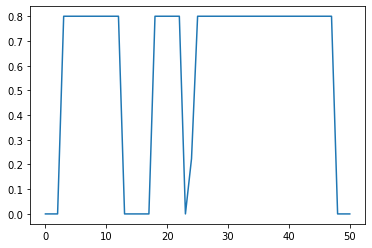

In [5]:
import json
import matplotlib.pyplot as plt
results = json.load(open("result.json"))

data = results["Ontario"]
plt.plot(data["Optimized Social Distancing"])

In [63]:
apm_get(server,app,'infeasibilities.txt')

NameError: name 'apm_get' is not defined